In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from scipy.stats import norm
from scipy.spatial.distance import cosine
import os
import decoupler as dc

In [2]:
data_path = '../Data/robustness_fig4/'

In [3]:
runs = os.listdir(data_path)

# if =='original' then insert at 0
for run in runs:
    if run == 'original':
        runs.insert(0, runs.pop(runs.index(run)))

In [4]:
factor_scores = []
lr_loadings = []

W_matrices = []  # Store W matrices from each run
H_matrices = []  # Store H matrices
feature_indices = []  # Store feature indices

for run in runs:
    fs = pd.read_csv(data_path + run + '/factor_scores_fig4.csv', index_col='index').drop('Unnamed: 0', axis=1)
    W_matrices.append(fs.values)
    fs['run'] = run
    factor_scores.append(fs)
    
    lr = pd.read_csv(data_path + run + '/lr_loadings_fig4.csv', index_col='index')
    H_matrices.append(lr.values.T)
    lr['run'] = run
    lr_loadings.append(lr)
    feature_indices.append(lr.index)

In [5]:
# original run indices
idx = feature_indices[0]

index_df = pd.DataFrame(columns=['Run', 'idx1', 'idx2'])
for i in range(0, len(runs)):
    idx2 = feature_indices[i]
    common = idx.intersection(idx2)
    index_df.loc[i] = [runs[i],
                       np.where(idx.isin(common))[0],
                       np.where(idx2.isin(common))[0]]

Compare Projection Similarity (Fancy): 0=perfect, 1=no similarity

In [6]:
def normalized_projection_error(A, B):
    """
    Calculate the normalized projection error between two sets of NMF components.
    
    Parameters:
    - A: Factor loadings from NMF run 1 (samples x components)
    - B: Factor loadings from NMF run 2 (samples x components)
    
    Returns:
    - normalized_error: Normalized Frobenius norm of the difference between B and its projection onto A
    """
    # Project B onto the space of A
    A_pinv = np.linalg.pinv(A)  # Pseudo-inverse of A
    A_I = (A @ A_pinv)
    # print(A_I)
    B_projected = A_I @ B  # Projection of B onto the column space of A
    
    # Calculate the Frobenius norm of the difference and normalize
    projection_error = np.linalg.norm(B - B_projected, 'fro')
    normalized_error = projection_error / np.linalg.norm(B, 'fro')
    
    return normalized_error

In [7]:
# generate 100 permutations of random matrices and calculate the normalized projection error
n_permutations = 10 # NOTE: increase this
n_obs = W_matrices[0].shape[0]
random_errors = np.zeros(n_permutations)

B = W_matrices[0]
rng = np.random.default_rng(42)

for i in range(n_permutations):
    random_indices = rng.permutation(n_obs)
    A = B[random_indices, :]
    
    # random A
    # A = rng.uniform(size=B.shape)
    random_errors[i] = normalized_projection_error(A, B)

In [8]:
projection_errors = []
# pairwise similarity scores with 1st run
for i in range(1, len(W_matrices)):
    score = normalized_projection_error(W_matrices[i], W_matrices[0])
    projection_errors.append(score)
projection_errors = pd.DataFrame(data=projection_errors, index=runs[1:], columns=['errors'])
projection_errors.index = projection_errors.index.str.replace('cutoff', '').astype(int)
projection_errors = projection_errors.sort_index()

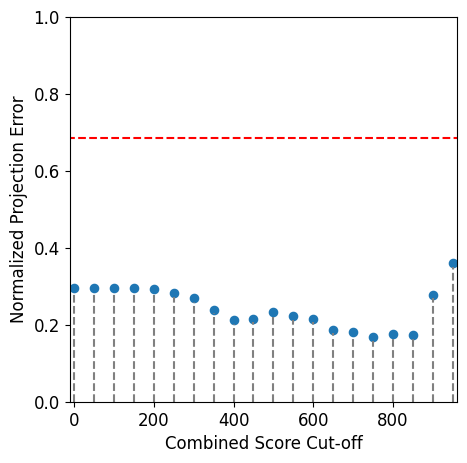

In [9]:
# scatter plot of range of features vs similarity scores
from matplotlib import rcParams
rcParams.update({'font.size': 12})
plt.figure(figsize=(5, 5))
# fontsize to 12
plt.scatter(x=projection_errors.index, y=projection_errors['errors'], s=35)
plt.ylabel('Normalized Projection Error')
plt.ylim(0, 1)
plt.vlines(x=projection_errors.index, ymin=0, ymax=projection_errors['errors']-0.01, color='gray', linestyle='dashed')
plt.hlines(y=random_errors.mean(), xmin=-100, xmax=1000, color='red', linestyle='dashed')
plt.xlim(-11, 961)
plt.xlabel('Combined Score Cut-off')
plt.show()

In [11]:
mu, std = norm.fit(random_errors)
# Calculate the z-score of the original value
z_scores = (projection_errors - mu) / std
# Calculate the probability of getting a value >= original_value under the fitted distribution
p_values = norm.cdf(projection_errors, mu, std)

In [12]:
B = W_matrices[1]
A = W_matrices[0]

In [13]:
A_pinv = np.linalg.pinv(A)
B_projected = A @ A_pinv @ B

In [14]:
# project a random W
random_W = rng.uniform(size=B.shape)
random_W_projected = A @ A_pinv @ random_W

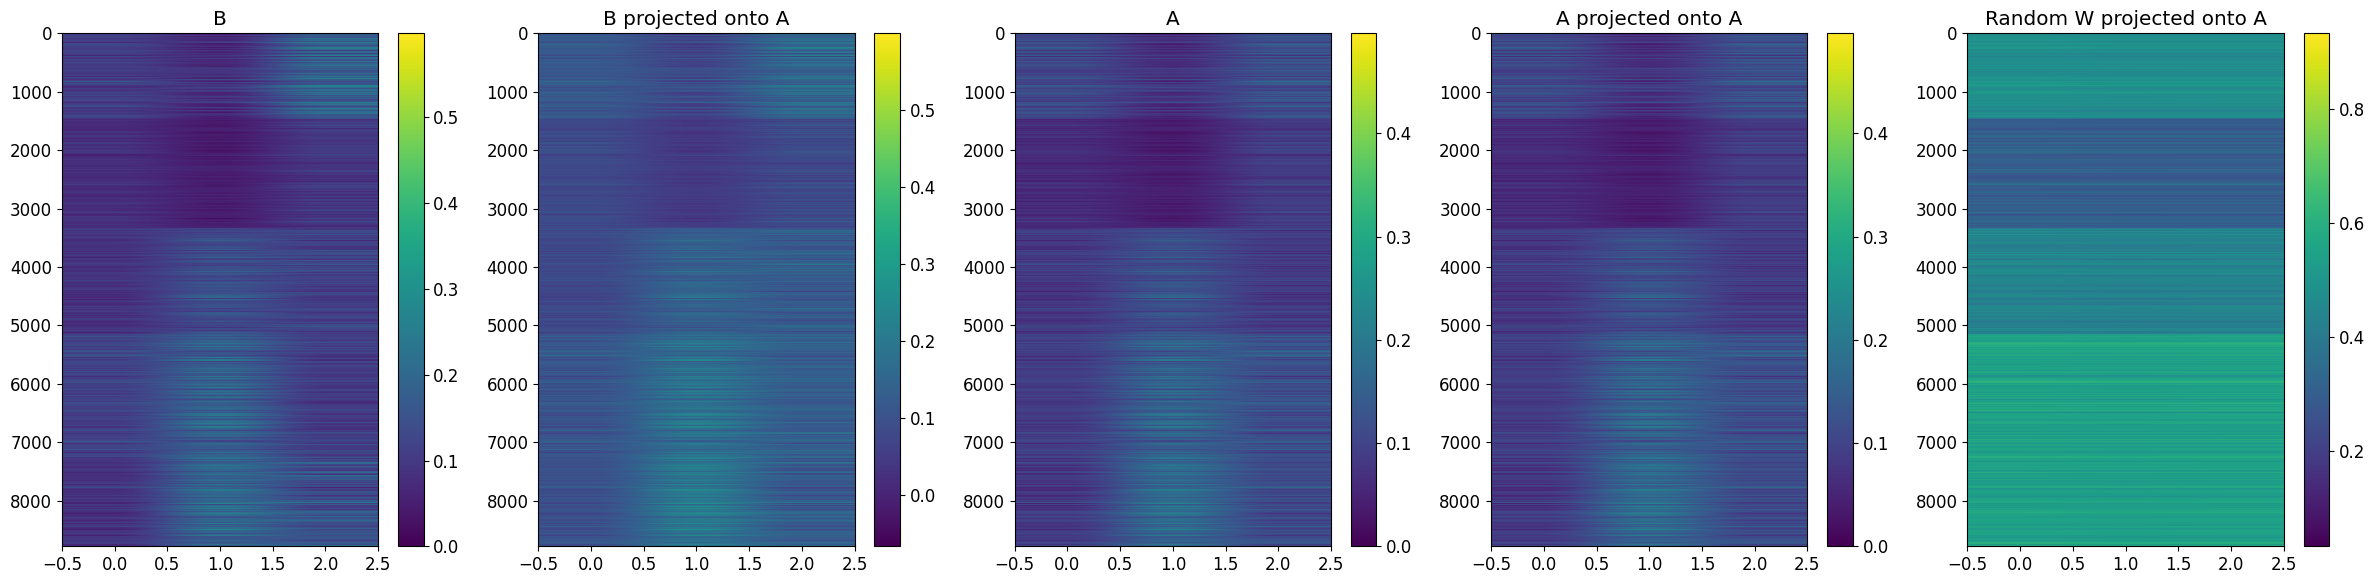

In [15]:
# plot B, B_projected, A, and random_W_projected
plt.figure(figsize=(24, 6))
plt.subplot(1, 5, 1)
plt.imshow(B, aspect='auto')
plt.title('B')
plt.colorbar()
plt.subplot(1, 5, 2)
plt.imshow(B_projected, aspect='auto')
plt.title('B projected onto A')
plt.colorbar()
plt.subplot(1, 5, 3)
plt.imshow(A, aspect='auto')
plt.title('A')
plt.colorbar()
plt.subplot(1, 5, 4)
plt.imshow(A @ A_pinv @ A , aspect='auto')
plt.title('A projected onto A')
plt.colorbar()
plt.subplot(1, 5, 5)
plt.imshow(random_W_projected, aspect='auto')
plt.title('Random W projected onto A')
plt.colorbar()
plt.tight_layout()
plt.show()

Re-order Corresponding Factors

In [16]:
def find_corresponding_factors(W1, W2):
    """Find the best match factors in W2 for each factor in W1 based on cosine similarity."""
    mappings = []
    for i in range(W1.shape[1]):
        max_similarity = -np.inf
        best_match = None
        for j in range(W2.shape[1]):
            similarity, _ = pearsonr(W1[:, i], W2[:, j])
            # similarity = -1 * cosine(W1[:, i], W2[:, j])
            if similarity > max_similarity:
                max_similarity = similarity
                best_match = j
        print(f'Factor{i+1}', f'Factor{best_match+1}', similarity)
        mappings.append(best_match)
    return mappings

def compute_mappings_to_original(W_matrices):
    """Compute mappings for each run's factors to the first run's factors."""
    num_runs = len(W_matrices)
    mappings = [list(range(W_matrices[0].shape[1]))]  # First run maps to itself
    for i in range(1, num_runs):
        print(runs[i])
        mapping = find_corresponding_factors(W_matrices[0], W_matrices[i])
        mappings.append(mapping)
    return mappings

# Assume W_matrices contains all factor loading matrices from different runs
mappings = compute_mappings_to_original(W_matrices)


cutoff400
Factor1 Factor3 0.855361371658939
Factor2 Factor2 -0.17575461284435967
Factor3 Factor1 -0.33002776045931836
cutoff850
Factor1 Factor1 -0.12896479156072843
Factor2 Factor2 -0.35249444432066046
Factor3 Factor3 0.9563687397634161
cutoff350
Factor1 Factor3 0.8161850455464355
Factor2 Factor1 -0.16585897394478266
Factor3 Factor2 -0.33285609024707646
cutoff450
Factor1 Factor3 0.8543078634114623
Factor2 Factor2 -0.19110467584381227
Factor3 Factor1 -0.3209861032110208
cutoff600
Factor1 Factor3 0.8709410128912604
Factor2 Factor2 -0.22063409279638102
Factor3 Factor1 -0.308671502816478
cutoff900
Factor1 Factor2 -0.03978226922970193
Factor2 Factor1 -0.37837930708463685
Factor3 Factor3 0.8649216325786996
cutoff200
Factor1 Factor3 0.77097509340709
Factor2 Factor1 -0.18015843899574663
Factor3 Factor2 -0.2752166962703263
cutoff50
Factor1 Factor3 0.7856054775905272
Factor2 Factor1 -0.19312782658610084
Factor3 Factor2 -0.25445254219104807
cutoff150
Factor1 Factor3 0.7856054775905272
Factor2 Fac

In [17]:
def reorder_factors(W_matrices, mappings):
    """Reorder each run's factors according to the mapping to the first run."""
    reordered_matrices = []
    for W, mapping in zip(W_matrices, mappings):
        reordered_matrix = W[:, mapping]
        reordered_matrices.append(reordered_matrix)
    return reordered_matrices

reordered_W_matrices = reorder_factors(W_matrices, mappings)

def reorder_loadings(H_matrices, mappings):
    """Reorder each run's loadings according to the mapping to the first run."""
    reordered_matrices = []
    for H, mapping in zip(H_matrices, mappings):
        reordered_matrix = H[mapping, :]
        reordered_matrices.append(reordered_matrix)
    return reordered_matrices

reordered_H_matrices = reorder_loadings(H_matrices, mappings)


In [18]:
correlation_loadings = pd.DataFrame(columns=['Run', 'Factor', 'Correlation', 'P-value'])
for i in range(1, len(W_matrices)):
    H1 = reordered_H_matrices[0][:, index_df['idx1'].values[i]]
    H2_ro = reordered_H_matrices[i][:, index_df['idx2'].values[i]]
    for j in range(H1.shape[0]):
        corr, pval = spearmanr(H1[j], H2_ro[j])
        correlation_loadings.loc[len(correlation_loadings)] = [runs[i], f"Factor{j+1}", corr, pval]
correlation_loadings['Run'] = correlation_loadings['Run'].str.replace('cutoff', '').astype(int)

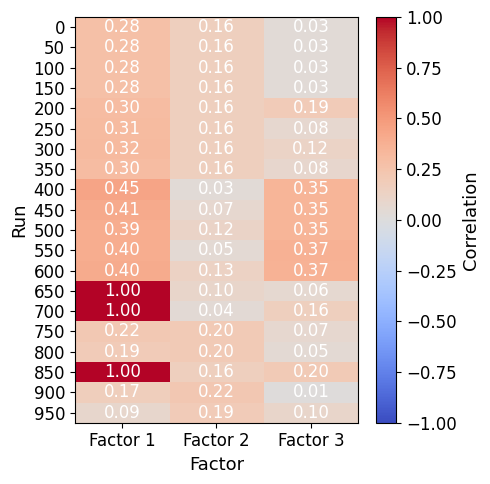

In [19]:
plt.figure(figsize=(5, 5))

# Create a pivot table for the heatmap
pivot_table = correlation_loadings.pivot(index='Run', columns='Factor', values='Correlation')
# create a pivot table for p-values to be used a cell annotations
p_values = correlation_loadings.pivot(index='Run', columns='Factor', values='P-value')
plt.imshow(pivot_table, cmap='coolwarm', aspect='auto')
plt.colorbar().set_label('Correlation', size=13)
# cbar lim 0, 1
plt.clim(-1, 1)

# annotate with p-values
for i in range(pivot_table.shape[0]):
    for j in range(pivot_table.shape[1]):
        plt.text(j, i, f'{pivot_table.iloc[i, j]:.2f}', ha='center', va='center', color='white', size=12) # \n({p_values.iloc[i, j]:.3f})

plt.xlabel('Factor', size=13)
plt.ylabel('Run', size=13)
plt.xticks(range(3), [f'Factor {i+1}' for i in range(3)], size=12)
plt.yticks(range(len(pivot_table)), pivot_table.index, size=12)
plt.tight_layout()

In [20]:
factor_scores

[                           Factor1   Factor2   Factor3       run
 index                                                           
 fsham-AAACAAGTATCTCCCA-1  0.107739  0.000000  0.177709  original
 fsham-AAACCGGGTAGGTACC-1  0.056355  0.050258  0.232002  original
 fsham-AAACCGTTCGTCCAGG-1  0.095256  0.045474  0.122207  original
 fsham-AAACCTCATGAAGTTG-1  0.195532  0.009619  0.102481  original
 fsham-AAACGAGACGGTTGAT-1  0.019195  0.312634  0.058665  original
 ...                            ...       ...       ...       ...
 f6wks-TTGTGTTTCCCGAAAG-1  0.143241  0.144524  0.217664  original
 f6wks-TTGTTAGCAAATTCGA-1  0.267101  0.046797  0.110413  original
 f6wks-TTGTTCAGTGTGCTAC-1  0.256084  0.101479  0.028492  original
 f6wks-TTGTTGTGTGTCAAGA-1  0.017046  0.209528  0.192385  original
 f6wks-TTGTTTCCATACAACT-1  0.015025  0.413651  0.000000  original
 
 [8784 rows x 4 columns],
                            Factor1   Factor2   Factor3        run
 index                                         

In [21]:
net = lr_loadings[0].sort_values(by='Factor1', ascending=False).head(20).reset_index()[['index','Factor1']].rename(columns={'index':'target', 'Factor1':'weight'})
net['source'] = 'top'

In [67]:
ora = []
for i in range(len(runs[1:])):
    mat = lr_loadings[i].drop('run',axis=1).T
    mat.columns.name = None
    if net['target'].isin(mat.columns).sum() > 5:
        print(runs[i])
        est, pvals = dc.run_ora(mat=mat,
                                net=net,
                                n_background=mat.shape[1])
        est = est.rename(columns={'top':'-log10(pval)'})
        pvals = pvals.rename(columns={'top':'pval'})
        scores = est.merge(pvals, left_index=True, right_index=True)
        scores['run'] = runs[1:][i]
        ora.append(scores)
ora = pd.concat(ora)
ora['run'] = ora['run'].str.replace('cutoff', '').astype(int)
# NOTE: some bug with ora, and sets the sample names to source
ora = ora.reset_index().rename(columns={'index':'Factor'})
ora = ora.sort_values(by='run')
ora['fdr'] = dc.p_adjust_fdr(ora['pval'])

original
cutoff400
cutoff850
cutoff350
cutoff450
cutoff600
cutoff900
cutoff200
cutoff50
cutoff150
cutoff550
cutoff300
cutoff650
cutoff700
cutoff500
cutoff0
cutoff100
cutoff750
cutoff800


Text(-8.277777777777782, 0.5, 'Cutoff')

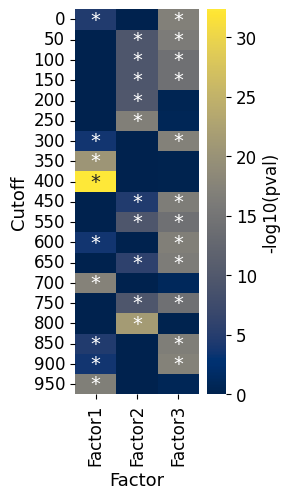

In [82]:
# heatmap
import seaborn as sns
plt.figure(figsize=(2, 5))
pivot_table = ora.pivot(index='Factor', columns='run', values='-log10(pval)').T
pivot_pvals = ora.pivot(index='Factor', columns='run', values='fdr').T
# pvals as asterisks
pivot_pvals = pivot_pvals.applymap(lambda x: '*' if x < 0.05 else '')
sns.heatmap(pivot_table, cmap='cividis', annot=pivot_pvals, cbar_kws={'label': '-log10(pval)'}, fmt='s', annot_kws={'size': 14})

# don't rotate y title
plt.yticks(rotation=0)
plt.xlabel('Factor', size=13)
plt.ylabel('Cutoff', size=13)